<h1><center> Reflectometry Data Analysis and Simulation Software </center></h1>
 <h2><center> - Simulation Intercomparison - </center></h2>

![Bornagain multilayer reflectometry model](multilayer.png)

The aim of this notebook is to provide a quick comparison between **BornAgain** and other available software packages devoted to simulate and fit neutron scattering reflectometry data. To this end, the simulation described in the following BornAgain documentation page is used as benchmark:

https://www.bornagainproject.org/documentation/working-with-python/basic-simulation-tutorial/reflectometry/

As described in the link, the benchmark sample will consist of:

 - An ambient layer, used as initial media of beam propagation.
 - 10 stacked pairs of titanium-nickel bilayers.
 - A Silicon layer as a substrate
 
The wavelenght of the reflected neutron beam is set to $\lambda = 1.54\unicode{x212B}$ and the sampling angle $0^\circ < \theta < 2^\circ$.

In [1]:
#Location of the files to write and read the simulated data:
BornAgainDataFile="./Ti-Ni-SubSi-BornAgain.dat"
GenXDataFile="./Ti-Ni-SubSi-GenX.dat"
Refl1dDataFile="./Ti-Ni-SubSi-Refl1d.dat"
RefnxDataFile="./Ti-Ni-SubSi-Refnx.dat"
RefnxDataFileQ="./Ti-Ni-SubSi-Refnx-Qvals.dat"

#### BornAgain
The following cell contains the BornAgain script required to simulate reflectometry measurements from the aforementioned sample. The data the script generates is provided together with this notebook in the file _./Ti-Ni-SubSi-BornAgain.dat_

In [2]:
#BornAgain script for simulating some reflectometry data:
import bornagain as ba
from bornagain import deg, angstrom
import numpy as np


def get_sample():
    """
    Defines sample and returns it
    """

    # creating materials
    m_ambient = ba.MaterialBySLD("Ambient", 0.0, 0.0)
    m_ti = ba.MaterialBySLD("Ti", -1.9493e-06, 0.0)
    m_ni = ba.MaterialBySLD("Ni", 9.4245e-06, 0.0)
    m_substrate = ba.MaterialBySLD("SiSubstrate", 2.0704e-06, 0.0)

    # creating layers
    ambient_layer = ba.Layer(m_ambient)
    ti_layer = ba.Layer(m_ti, 30 * angstrom)
    ni_layer = ba.Layer(m_ni, 70 * angstrom)
    substrate_layer = ba.Layer(m_substrate)

    # creating multilayer
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(ambient_layer)
    for i in range(10):
        multi_layer.addLayer(ti_layer)
        multi_layer.addLayer(ni_layer)
    multi_layer.addLayer(substrate_layer)

    return multi_layer


def get_simulation():
    """
    Defines and returns a specular simulation.
    """
    simulation = ba.SpecularSimulation()
    theta = np.arange(0.002,2.002,0.002)
    #simulation.setBeamParameters(1.54 * angstrom, 1000, 0.002 * deg, 2.002 * deg)
    simulation.setBeamParameters(1.54 * angstrom, theta * deg)
    return simulation


def run_simulation():
    """
    Runs simulation and returns its result.
    """
    sample = get_sample()
    simulation = get_simulation()
    simulation.setSample(sample)
    simulation.runSimulation()
    return simulation.result()

results = run_simulation()
data = results.data()
intensity = data.getArray()
x_axis = data.getAxis(0).getBinCenters()
ymax = np.amax(intensity) * 2.0
ymin = max(np.amin(intensity) * 0.5, 1e-18 * ymax)
array_to_export = np.column_stack((x_axis, intensity))
np.savetxt(BornAgainDataFile,array_to_export)

#### GenX 

While in BornAgain materials are defined by their _SLD_, in GenX they are defined by their _unit cell density_ (see http://gisaxs.com/index.php/Scattering_Length_Density). This quantity is represented by the _dens_ parameter inside GenX and can be computed using the following equation:

$$\rm{dens} = \frac{N_\rm{A}}{V_{\rm m}[\unicode{x212B}^3]},$$

where $N_{\rm A}$ is the Avogadro's number and $V_{\rm m}$ is the molar volume. These quantities can be found in the following pages for each of the materials needed:

$Si$: http://periodictable.com/Elements/014/data.html ,

$Ti$: http://periodictable.com/Elements/022/data.html ,

$Ni$ : http://periodictable.com/Elements/028/data.html .

Plugging the corresponding values in the above equation, we obtain:

$${\rm dens}_{Si} \simeq 0.05$$

$${\rm dens}_{Ti} \simeq 0.0057$$

$${\rm dens}_{Ni} \simeq 0.091$$

Another difference between BornAgain and GenX is the way in which angles are defined:

$$\theta_\rm{GenX} = 2 \theta_\rm{BornAgain}.$$

This difference in definition must be borne in mind when comparing the reults from both codes.

The following cell contains the GenX script required to simulate reflectometry data obtained out of the benchmark sample. **Be aware that this script must be copied to the script editor inside GenX GUI; trying to run it in this notebook will produce an error.** The data it generates is provided together with this notebook in the file _./Ti-Ni-SubSi-GenX.dat_

Reference: http://genx.sourceforge.net/doc/tutorials/neutron_sim.html

In [3]:
#This script only makes sense if written inside GenX GUI. Trying to run it here will produce an error.
if False:
    from numpy import *
    import models.spec_nx as model
    from models.utils import UserVars, fp, fw, bc, bw
  
    # BEGIN Instrument DO NOT CHANGE
    from models.utils import create_fp, create_fw
    inst = model.Instrument(Ibkg=0.0, res=0.001, footype='no corr', I0=1.0, samplelen=10.0, probe='neutron', beamw=0.01, 
                            restype='no conv', tthoff=0.0, pol='uu', coords='tth', resintrange=2, 
                            wavelength=1.54, respoints=5, incangle=0.0,)
    inst_fp = create_fp(inst.wavelength); inst_fw = create_fw(inst.wavelength)
    
    fp.set_wavelength(inst.wavelength); fw.set_wavelength(inst.wavelength)
    # END Instrument
    
    # BEGIN Sample DO NOT CHANGE
    Amb = model.Layer(b=0j, d=0.0, f=(1e-20+1e-20j), dens=0.0001, sigma=0.0, magn_ang=0.0, xs_ai=0.0, magn=0.0)
    Ti = model.Layer(b=bc.Ti, d=30, f=fp.Ti, dens=0.057, sigma=0.0, magn_ang=0.0, xs_ai=0.0, magn=0.0)
    Ni = model.Layer(b=bc.Ni, d=70, f=fp.Ni, dens=0.091, sigma=0.0, magn_ang=0.0, xs_ai=0.0, magn=0.0)
    Sub = model.Layer(b=bc.Si, d=0.0, f=fp.Si, dens=0.05, sigma=0.0, magn_ang=0.0, xs_ai=0.0, magn=0.0)
    
    MyLAys = model.Stack(Layers=[Ni , Ti], Repetitions = 10)
    
    sample = model.Sample(Stacks = [MyLAys], Ambient = Amb, Substrate = Sub)
    # END Sample
    
    # BEGIN Parameters DO NOT CHANGE
    cp = UserVars()
    # END Parameters
    
    SLD = []
    def Sim(data):
        I = []
        SLD[:] = []
        # BEGIN Dataset 0 DO NOT CHANGE
        d = data[0]
        I.append(sample.SimSpecular(d.x, inst))
        if _sim: SLD.append(sample.SimSLD(None, None, inst))
        # END Dataset 0
        return I

#### Refl1d

Refl1d allows materials to be defined by its name, without explicitly stating their density or SLD.
The following cell contains the Refl1d script required to carry out the benchmark simulation. The data the script generates is provided together with this notebook in the file _./Ti-Ni-SubSi-Refl1d.dat_

Reference: https://refl1d.readthedocs.io/en/latest/tutorial/superlattice/PEMU.html

In [4]:
import refl1d.names as rfn
Ti = rfn.Material('Ti')
Ni = rfn.Material('Ni')
Si_substrate = rfn.Material('Si')
air = rfn.air

sample =  (Si_substrate(0,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | Ni(70,0) | Ti(30,0)
          | air)

# == Data ==
L = 1.54
theta = np.arange(0.002, 2.002, 0.002)
probe = rfn.NeutronProbe(T=theta, L=1.54)

# == Simulation == 
M = rfn.Experiment(probe=probe, sample=sample)
M.simulate_data()
intensity = M.reflectivity()[1]

# == Export output ==
array_to_export = np.column_stack((theta, intensity))
np.savetxt(Refl1dDataFile,array_to_export)

ImportError: No module named 'refl1d'

#### Refnx

Materials in Refnx are specified by their $SLD$, as in BornAgain. An important difference is instead the sampling independent variable: while in BornAgain it is the angle $\theta$, in Refnx it is the $Q$ vector. The relationship between this two quantities is given by:

$$Q_{\rm refnx} = 4\,\pi\,\frac{\sin\left(\frac{\theta_{\rm BA}[^\circ]}{180^\circ} \, \pi\right)}{\lambda[\unicode{x212B}]},$$

The following cell contains the Refnx script required to simulate the reflectivity benchmark.The data it generates is provided together with this notebook in the file _./Ti-Ni-SubSi-Refnx.dat_

Reference: https://refnx.readthedocs.io/en/latest/gui.html; https://refnx.readthedocs.io/en/latest/lipid.html

In [10]:
import numpy as np
import refnx
from refnx.analysis import Objective, CurveFitter
from refnx.reflect import SLD, Slab, ReflectModel, Structure
from refnx.dataset import ReflectDataset

# set up the SLD objects for each layer
sld_air = SLD(0.0 + 0.0j, name='air')
sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
sld_Si = SLD(2.0704 +  0.0j, name='Si')

# set up the Slab objects for each layer
slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

# set up the Structure object from the Slabs
structure = (
             slab_air 
            | slab_Ti | slab_Ni 
            | slab_Ti | slab_Ni 
            | slab_Si
            )

# make the reflectometry model
L = 1.54
theta = np.arange(0.002, 2.002, 0.002)

#Refnx requires the q vector as input coordinate
Qin = 4.0*np.pi*np.sin(theta*np.pi/180.0)/L
intensity = ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Qin)

array_to_export = np.column_stack((Qin, intensity))
np.savetxt(RefnxDataFileQ,array_to_export)

## Simulation results comparison

In the following cells, three figures are generated in which comparisons between BornAgain and the rest of the codes are offered. Qualitatively, the four codes --BornAgain, GenX, Refl1d and Refnx, produce the same results; quantitatively, there is some disagreement that is discussed later. 

The following cell is a convenient function to make a comparative figure and calculate the relative discrepancy between two codes.

In [6]:
#Function that makes a plot comparing the results from another code to BornAgain
import matplotlib.pyplot as plt
def plot_comparison(X,Y,OtherCodeName,BAX=np.array([]),BAY=np.array([]),BAcodename=np.array([])):
    """
    X = Theta
    Y = Intensity
    """
    if(np.size(BAX) == 0 or np.size(BAY) == 0 or np.size(BAcodename) == 0):
        BornAgain = np.loadtxt(BornAgainDataFile)
        BAX = BornAgain[:,0]
        BAY = BornAgain[:,1]
        BAcodename = "BornAgain"
    rel_error = 2.*np.abs(BAY-Y)/np.abs(BAY+Y)
    mean_err = rel_error.mean()
    
    
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(15,10))
    plt.semilogy(BAX,BAY, label = BAcodename)
    plt.semilogy(X,Y, label = OtherCodeName)
    plt.semilogy(BAX, rel_error,'k--', label = "Relative Error", alpha = 0.3)
    plt.axhline(y=mean_err,color='k', label="Mean Relative Error = $" + str(np.round(mean_err,3)) + "$")
    plt.ylim(1e-9,1e1)
    plt.xlim(min(BAX),max(BAX))
    plt.xlabel("$\\alpha_i[\\deg]$")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()
#plot_comparison(GenX_x,GenX_y,"GenX")

The following figures show the reflectivity profiles obtained in each code, GenX, Refl1d and Refnx [orange lines], as compared to the reflectivity profile obtained in BornAgain [blue lines]. The relative error for each data point [grey dashed line] and the mean relative error [black line] are also plotted.

#### BornAgain vs. GenX

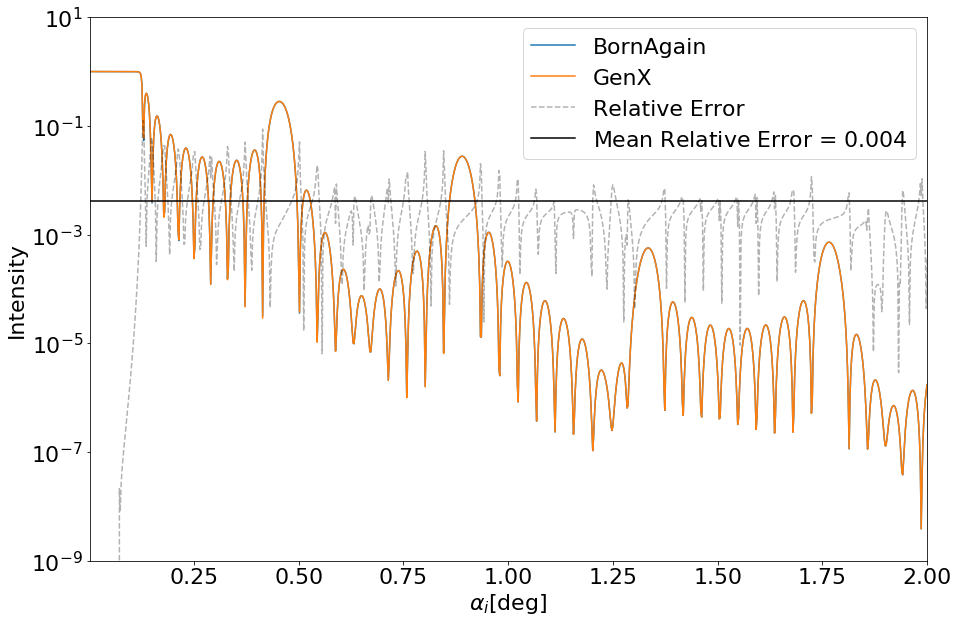

In [7]:
#Load the simulated data:
#data_arr = np.loadtxt(GenXDataFile)
data_arr = np.loadtxt("Ti-Ni-SubSi-GenX_extra_precision.dat")
#Theta coordinates:
x_data = data_arr[:,0]/2.
#Intensity values:
y_data = data_arr[:,1]
#Plot comparison:
plot_comparison(x_data,y_data,"GenX")

#### BornAgain vs. Refl1d

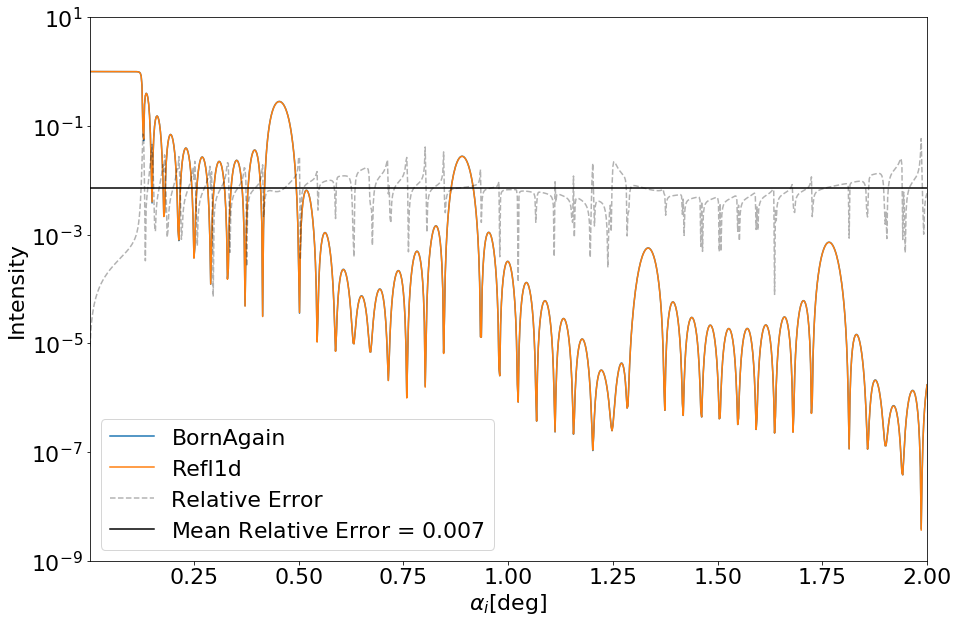

In [8]:
#Load the simulated data:
data_arr = np.loadtxt(Refl1dDataFile)
#Theta coordinates:
x_data = data_arr[:,0]
#Intensity values:
y_data = data_arr[:,1]
#Plot comparison:
plot_comparison(x_data,y_data,"Refl1d")

#### BornAgain vs. Refnx

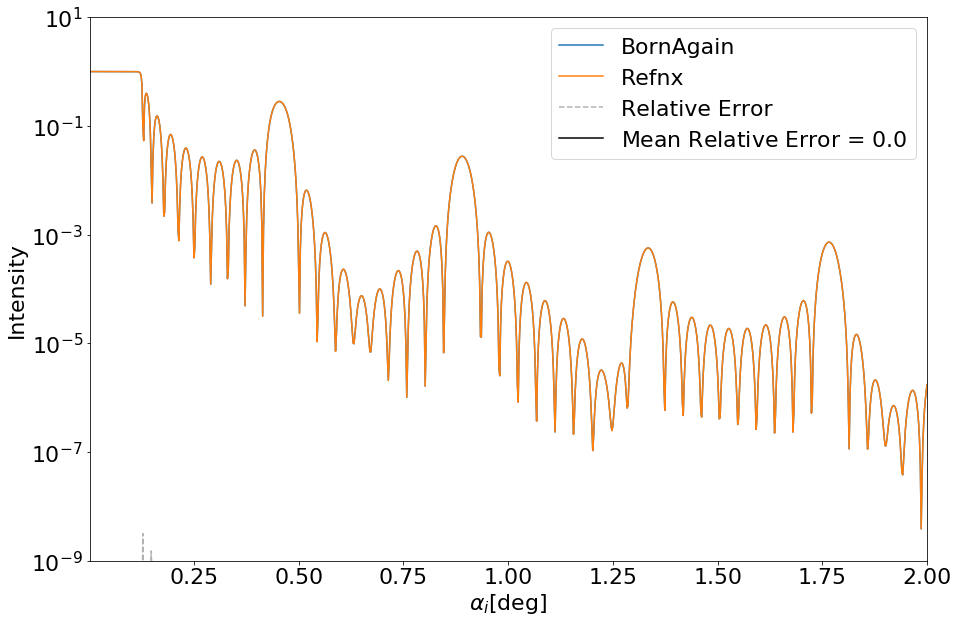

In [9]:
#Load the simulated data:
data_arr = np.loadtxt(RefnxDataFile)
#Theta coordinates:
x_data = data_arr[:,0]
#Intensity values:
y_data = data_arr[:,1]
#Plot comparison:
plot_comparison(x_data,y_data,"Refnx")

As already stated, qualitative agreement is absolutely reached. However, when measuring the relative error in the values obtained for the intensity profiles, $I(\theta)$, we note some disagreement,

$$\left<{\rm Relative Error}\right> = \left<2\,\frac{I_{\rm BA} - I_{\rm GenX}}{I_{\rm BA} + I_{\rm GenX}}\right> \sim 0.01.$$

#### Discrepancy of the results

As the units to define the simulations in each code are different (e.g. BornAgain uses SLDs and the angle $\theta[^\circ]$, GenX uses _unit cell densities_, Refl1d uses its own materials database and refnx uses the $Q$ vector instead of $\theta$), conversions between them may spoil the results.

In order to assess the impact of the lack of precision when switching units, a test with two different precisions was made using GenX. The error incurred by rounding the _dens_ parameter to 3 significant figures instead of 5 is shown in the following Figure.

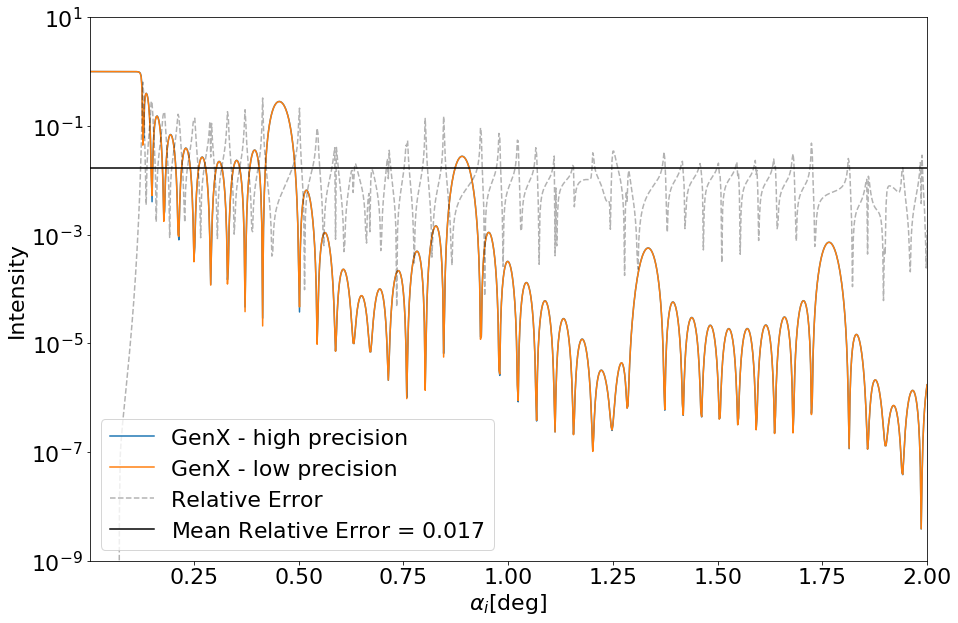

In [10]:
#Load the simulated data:
data_arr1 = np.loadtxt(GenXDataFile)
data_arr2 = np.loadtxt("Ti-Ni-SubSi-GenX_extra_precision.dat")
#Theta coordinates:
x_data1 = data_arr1[:,0]/2.
y_data1 = data_arr1[:,1]

x_data2 = data_arr2[:,0]/2.
y_data2 = data_arr2[:,1]
#Plot comparison:
plot_comparison(x_data1,y_data1,"GenX - low precision",x_data2,y_data2,"GenX - high precision")

We see that the lack of 2-digit precision during the conversion of units has an impact of $1.7\%$ in the mean relative error (i.e. impacts the second significant figure).

#### Summary

The mean relative error between BornAgain and each tested code is the following:


$${\rm Mean Relative Error[BornAgain-GenX]} \simeq 0.4\%$$
$${\rm Mean Relative Error[BornAgain-Refl1d]} \simeq 0.7\%$$
$${\rm Mean Relative Error[BornAgain-Refnx]} << 0.01\%$$
$${\rm Mean Relative Error[Low-High \,\, precision]} \simeq 1.7\%$$

The conclusion to extract is that, in order to have good agreement between results from different codes, care must be taken when _translating_ the parameters that define a simulation. However, to one's relief, 1. even if two significant figures are dropped, the mean relative error is still of the same order of magnitude --around $2\%$; and 2. In all cases tested, the mean relative error is dominated by points whose signal is already almost negligible.